# Libraries

In [ ]:
import tensorflow as tf
import random
import numpy as np
SEED = 10
random.seed(SEED)       # Sets seed for Python's built-in random module
np.random.seed(SEED)    # Sets seed for NumPy's random functions
tf.random.set_seed(SEED)  # Sets seed for TensorFlow's random operations

# Dataset

Minst Dataset

*   60,000 training images
*   10,000 test images
*   28x28 pixels (784 pixels)
*   Grayscale
*   Labled






In [ ]:
# Load and preprocess MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#Normalization
x_train = x_train.reshape(-1, 784).astype(np.float32) / 255.0
x_test = x_test.reshape(-1, 784).astype(np.float32) / 255.0

#One-Hot-Encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

#Training Set
x_train_subset = x_train[:5000]
y_train_subset = y_train[:5000]

#Testing Set
x_test_subset = x_test[:10000]
y_test_subset = y_test[:10000]

# Neural Network

In [ ]:
#ReLU activation (for hidden layer)
def relu(x):
    return np.maximum(0, x)

#Softmax activation (for output layer)
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))#We subtract to avoid big numbers when we take the exponential,This helps with numerical stability.
    return e_x / np.sum(e_x, axis=1, keepdims=True)

# Vector decoding (update dimensions to match 32 hidden units)
def decode_vector(vector):
    W1 = vector[0:25088].reshape((784, 32))
    b1 = vector[25088:25120].reshape((32,))
    W2 = vector[25120:25440].reshape((32, 10))
    b2 = vector[25440:25450].reshape((10,))
    return W1, b1, W2, b2

# Model forward pass
def forward(X, W1, b1, W2, b2):
    Z1 = X @ W1 + b1      # Linear part
    A1 = relu(Z1)         # Apply ReLU
    Z2 = A1 @ W2 + b2     # Linear part
    A2 = softmax(Z2)      # Apply softmax
    return A2

def cross_entropy(preds, targets, eps=1e-12):
    preds = np.clip(preds, eps, 1 - eps)  # Avoid log(0) which is undefined and log(1) as it is = 0 , range = (eps , 1 - eps)
    return -np.mean(np.sum(targets * np.log(preds), axis=1))

def fitness_function(vector):
    #Vector Decoding
    W1, b1, W2, b2 = decode_vector(vector)

    #Forward pass
    probs = forward(x_train_subset, W1, b1, W2, b2)

    #Cross-entropy loss
    ce_loss = cross_entropy(probs, y_train_subset)

    return ce_loss

# He initialization for 32 ReLU units , ""weight = np.random.randn(...) * sqrt(2 / n)""scaling the randoms
def he_vector(input_dim=784, hidden_dim=32, output_dim=10):
    w1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2 / input_dim)
    b1 = np.zeros(hidden_dim)
    w2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2 / hidden_dim)
    b2 = np.zeros(output_dim)
    return np.concatenate([w1.flatten(), b1, w2.flatten(), b2])

# GA Methods

**Selection**

In [ ]:
#Parent Selection
def tournament_selection(population, fitness, k):
    indices = np.random.choice(len(population), k, replace=False)
    best_idx = indices[np.argmin(fitness[indices])]
    return population[best_idx]

#Survivor Selection
def elitism(parents, parent_fitness, offspring, offspring_fitness, num_elites=2):
    # Select best 'num_elites' parents (lowest loss)
    elite_indices = np.argpartition(parent_fitness, num_elites)[:num_elites]
    elites = parents[elite_indices]
    elite_fitness = parent_fitness[elite_indices]

    # Select best offspring to fill remaining spots
    num_remaining = len(parents) - num_elites
    best_offspring_indices = np.argpartition(offspring_fitness, num_remaining)[:num_remaining]
    selected_offspring = offspring[best_offspring_indices]
    selected_offspring_fitness = offspring_fitness[best_offspring_indices]

    # Combine elites and selected offspring
    new_population = np.vstack((elites, selected_offspring))
    new_fitness = np.concatenate((elite_fitness, selected_offspring_fitness))

    return new_population, new_fitness

**Crossover**

In [ ]:
def blx_alpha_crossover(p1, p2, alpha = 0.5):
    p1, p2 = np.array(p1), np.array(p2)
    assert p1.shape == p2.shape, "Parents must have the same shape"
    diff = np.abs(p1 - p2)
    low = np.minimum(p1, p2) - alpha * diff
    high = np.maximum(p1, p2) + alpha * diff
    return np.random.uniform(low, high) , np.random.uniform(low, high)

def arithmetic_crossover(p1, p2, alpha):  # Common fixed value
    p1, p2 = np.array(p1), np.array(p2)
    assert p1.shape == p2.shape, "Parents must have the same shape"
    return alpha * p1 + (1 - alpha) * p2, alpha * p2 + (1 - alpha) * p1

**Mutation**

In [ ]:
def gaussian_mutation(individual,sigma , rate=0.01):
    individual = np.asarray(individual)
    mutant = individual.copy()
    mask = np.random.rand(*mutant.shape) < rate
    if np.any(mask):
        mutant[mask] += np.random.normal(0, sigma, size=np.sum(mask))
    return mutant

def cauchy_mutation(ind, sigma):
    ind = np.asarray(ind)
    mutation = np.random.standard_cauchy(size=ind.shape) * sigma
    return ind + mutation

**Parallel**

In [ ]:
from joblib import Parallel, delayed
# === Parallel fitness evaluation helper ===
def parallel_fitness(pop):
    return np.array(Parallel(n_jobs=-1)(delayed(fitness_function)(ind) for ind in pop))

# GA Island Model

In [ ]:
def init_islands(pop_size, num_islands):
    total_size = pop_size * num_islands
    total_pop = np.array([he_vector() for _ in range(total_size)])
    total_fit = parallel_fitness(total_pop)

    # Randomly shuffle and split into islands
    indices = np.random.permutation(total_size)
    pop_shuffled = total_pop[indices]
    fit_shuffled = total_fit[indices]

    islands = np.array_split(pop_shuffled, num_islands)
    fits = np.array_split(fit_shuffled, num_islands)

    return list(islands), list(fits)

In [ ]:
def evolve_all_islands(islands, fits, pop_size):
    num_islands = len(islands)
    new_islands = []
    new_fits = []

    # Crossover and mutation settings per island
    crossover_funcs = [arithmetic_crossover, blx_alpha_crossover, blx_alpha_crossover, arithmetic_crossover]
    mutation_funcs = [gaussian_mutation, cauchy_mutation, gaussian_mutation, cauchy_mutation]
    alpha_values = [0.5, 0.1, 0.1, 0.5]
    mutation_scales = [0.02, 0.1, 0.1, 0.1]

    for i in range(num_islands):
        pop = np.array(islands[i])
        fit = np.array(fits[i])
        offspring = []

        # Generate offspring
        for _ in range(pop_size // 2):
            # Parent selection
            p1 = tournament_selection(pop, fit, k=3)
            p2 = tournament_selection(pop, fit, k=3)

            # Crossover
            c1, c2 = crossover_funcs[i](p1, p2, alpha=alpha_values[i])

            # Mutation
            c1 = mutation_funcs[i](c1, sigma=mutation_scales[i])
            c2 = mutation_funcs[i](c2, sigma=mutation_scales[i])

            offspring.extend([c1, c2])

        offspring = np.array(offspring)

        # Evaluate fitness
        offspring_fitness = parallel_fitness(offspring)

        #Survivor selection
        new_pop, new_fit = elitism(pop, fit, offspring, offspring_fitness, num_elites=2)

        new_islands.append(new_pop)
        new_fits.append(new_fit)

    return new_islands, new_fits

In [ ]:
def ga(vector_size, pop_size=20, generations=3000, migration_interval=50, num_islands=4):
    #Initialization
    islands, fits = init_islands(pop_size, num_islands)
    loss_history = []


    for gen in range(generations):
        #Evolve one generation
        islands, fits = evolve_all_islands(islands, fits, pop_size)


        # Migration
        if gen % migration_interval == 0 and gen > 0:
            #Migrants
            migrant_pool = [island[np.random.choice(pop_size, 2, replace=False)] for island in islands]

            #Apply Migrations
            for i in range(num_islands):
                next_i = (i + 1) % num_islands
                worst_idx = np.argsort(fits[next_i])[-2:]
                islands[next_i][worst_idx[0]] = migrant_pool[i][0]
                islands[next_i][worst_idx[1]] = migrant_pool[i][1]
                fits[next_i][worst_idx] = parallel_fitness(migrant_pool[i])

        # Logging
        best_loss = np.min(fits)
        loss_history.append(best_loss)

        if gen % 50 == 0:
            print(f"[Gen {gen:04d}] Best Loss: {best_loss:.4f}")
            for i in range(num_islands):
                print(f"  Island {i+1} | Best: {np.min(fits[i]):.4f} | Avg: {np.mean(fits[i]):.4f}")

    all_pop = np.vstack(islands)
    all_fit = np.concatenate(fits)
    return all_pop[np.argmin(all_fit)], loss_history

# Run

In [ ]:
# Set seed for reproducibility
np.random.seed(SEED)
best_solution , loss_history = ga(vector_size=25450)

[Gen 0000] Best Loss: 2.2867
  Island 1 | Best: 2.2885 | Avg: 2.3094
  Island 2 | Best: 2.2880 | Avg: 21.9661
  Island 3 | Best: 2.2884 | Avg: 2.3507
  Island 4 | Best: 2.2867 | Avg: 22.1136
[Gen 0050] Best Loss: 1.8903
  Island 1 | Best: 2.2136 | Avg: 4.2612
  Island 2 | Best: 2.2173 | Avg: 19.4967
  Island 3 | Best: 1.8903 | Avg: 4.1590
  Island 4 | Best: 1.9087 | Avg: 19.0778
[Gen 0100] Best Loss: 1.6015
  Island 1 | Best: 1.9087 | Avg: 3.2286
  Island 2 | Best: 2.1339 | Avg: 19.7298
  Island 3 | Best: 1.6015 | Avg: 2.7590
  Island 4 | Best: 1.6051 | Avg: 19.3025
[Gen 0150] Best Loss: 1.3423
  Island 1 | Best: 1.8328 | Avg: 3.8096
  Island 2 | Best: 1.8340 | Avg: 19.8189
  Island 3 | Best: 1.3423 | Avg: 3.6454
  Island 4 | Best: 1.3577 | Avg: 18.7544
[Gen 0200] Best Loss: 1.1329
  Island 1 | Best: 1.3589 | Avg: 2.9039
  Island 2 | Best: 1.7436 | Avg: 19.2389
  Island 3 | Best: 1.1329 | Avg: 3.4677
  Island 4 | Best: 1.1396 | Avg: 19.1781
[Gen 0250] Best Loss: 0.9771
  Island 1 | Bes

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Decode weights and predict
decoded_weights = decode_vector(best_solution)
predictions_test = forward(x_test_subset, *decoded_weights)
predictions_train = forward(x_train_subset, *decoded_weights)

# Labels and accuracy
predicted_labels = np.argmax(predictions_test, axis=1)
true_labels = np.argmax(y_test_subset, axis=1)
test_accuracy = np.mean(predicted_labels == true_labels)
train_accuracy = np.mean(np.argmax(predictions_train, axis=1) == np.argmax(y_train_subset, axis=1))

print(f"\nFinal Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")


Final Train Accuracy: 94.70%
Final Test Accuracy: 90.08%


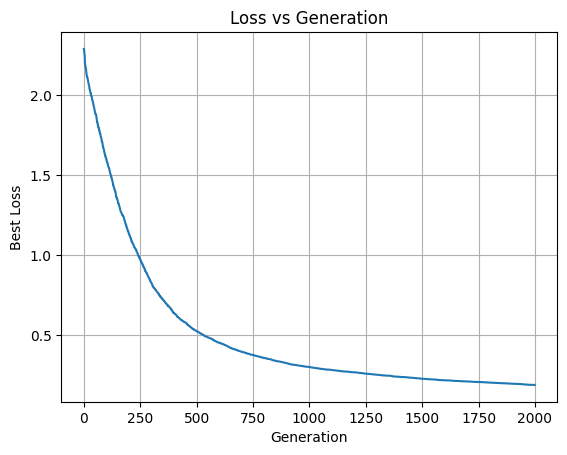

In [ ]:
# Plot loss per generation
plt.plot(loss_history, label='Loss')
plt.xlabel('Generation')
plt.ylabel('Best Loss')
plt.title('Loss vs Generation')
plt.grid(True)
plt.show()

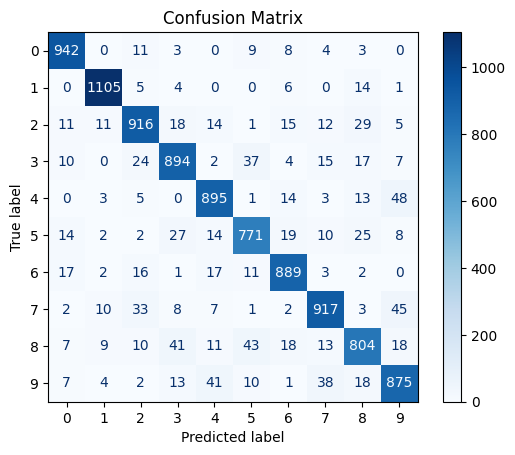

In [ ]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()